In [28]:
# !pip3 install pydot
# !pip3 install wandb
# Get helper_functions.py script from course GitHub
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [29]:
import wandb
# wandb.login()
# wandb.tensorboard.patch(root_logdir="logs")
# wandb.init(project="Food_not_Food", sync_teensorboard=True)

In [30]:
import tensorflow as tf
import os
tf.get_logger().setLevel('INFO')

In [31]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [32]:
# !ls data/model_test_images/

## Create train/test

In [33]:
# !mkdir data/train
# !mkdir data/test

In [34]:
# Make splits of images


In [35]:
target_dirs = os.listdir("data/model_test_images")
target_dirs

['.DS_Store', 'test', 'ball', 'train', 'advocate']

In [36]:
# train_split = (int(0.8 * len(ball_images)))
# train_split

In [37]:
# import numpy as np

# # Get random indexs of certain number from list of images
# train_idx = np.arange(len(ball_images))
# train_idx

In [38]:
# import random
# def create_train_test_list(target_dir):
#     random.seed(42)
#     image_list = [os.path.join(target_dir,img_path) for img_path in os.listdir(target_dir)]
#     train_split = int(0.8 * len(image_list))
#     train_image_list = random.sample(image_list,train_split)
#     test_image_list = list(set(image_list).difference(set(train_image_list)))
#     return train_image_list, test_image_list


# train_image_list, test_image_list = create_train_test_list("data/model_test_images/ball")


In [39]:
# len(train_image_list), len(test_image_list)

In [40]:
# # Create a function to move images
# from shutil import copy2
# def copy_images_to_file(img_path_list, target_dir,train=True):
#         if train:
#             # Make target directory
#             # split_dir = "train"
#             # print(img_path_list[0])
#             # dir_to_make = os.path.join(target_dir,split_dir)
#             # target_dir = os.path.join(target_dir , "train",)
#             # os.makedirs(os.path.join(target_dir,split_dir) , exist_ok = True)
#             split_dir = "train"
#         else:
#             split_dir = "test"
#             # os.makedirs(os.path.join(target_dir, split_dir) , exist_ok = True)

#         # Copy images
#         for image_path in img_path_list:
#             image_file_name = os.path.split(image_path)[-1]
#             dest_path = os.path.join(target_dir, split_dir, image_dir, image_file_name)
#             print(f"Copying: \n{image_path} to \n{dest_path}")
#             copy2(image_path, dest_path)


In [41]:
# data_dir = "data/model_test_images"
# target_dir = "data/model_test_images_split"
# for image_dir in os.listdir(data_dir):
#     # print(image_dir)

#     for split_dir in [ "train", "test"]:
#         os.makedirs(os.path.join(target_dir, split_dir, image_dir) , exist_ok= True)

#     # Make training and test lists of target images
#     train_image_list , test_image_list = create_train_test_list(os.path.join(data_dir, image_dir))

#     # Copy training images
#     copy_images_to_file(img_path_list = train_image_list, 
#                         target_dir = target_dir,
#                         train=True)

#     # Copt test images 
#     copy_images_to_file(img_path_list = test_image_list, 
#                         target_dir = target_dir,
#                         train=False)

In [42]:
# Next
# Make model tataset from train/test folders
# Build a model on train/test datasets
# Evaluate model
# Convert model to tfilte for deployment

## Load data

In [43]:
import tensorflow as tf

In [44]:
train_dir = "data/train"
test_dir = "data/test"
train_dir, test_dir

('data/train', 'data/test')

In [45]:
total_samples = len(os.listdir(train_dir))
num_food_samples = len(os.listdir(os.path.join(train_dir,"food_images")))
num_non_food_samples = len(os.listdir(os.path.join(train_dir,"non_food_images")))
total_samples, num_food_samples, num_non_food_samples

(3, 867, 13096)

In [46]:
# Since we have a data imbalance let's get class weights

# Scaling by total/2 helps keep the loss to a similar magnitue
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / num_food_samples) * (total_samples / 2.0)
weight_for_1 = (1 / num_non_food_samples) * (total_samples / 2.0)

class_weight = {0: weight_for_0, 1:weight_for_1}

print(f'Weight for class 0: {weight_for_0}')
print(f'Weight for class 1: {weight_for_1}')

Weight for class 0: 0.0017301038062283738
Weight for class 1: 0.00011453879047037264


In [47]:
# Load in data
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
    batch_size=32,
    image_size=(224,224)
) 
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
    batch_size=32,
    image_size=(224,224)
) 
train_data, test_data

Found 13902 files belonging to 2 classes.
Found 3479 files belonging to 2 classes.


(<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [48]:
# Scale class weights
total = len(train_data)


In [49]:
train_data.class_names

['food_images', 'non_food_images']

In [50]:
# Small model with two classes

## Build the first model

In [51]:
train_data = train_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

In [52]:
# Replace top with our image
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# base_model
# Make model untrainable
base_model.trainable = False

# Build a functional model
input_layer = tf.keras.layers.Input (shape = (224,224,3))
x = base_model(input_layer)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output_layer = tf.keras.layers.Dense(1,activation="sigmoid")(x)

# Construct model
model_1 = tf.keras.Model(input_layer, output_layer, name ="EfficientNetB0-V1")
model_1

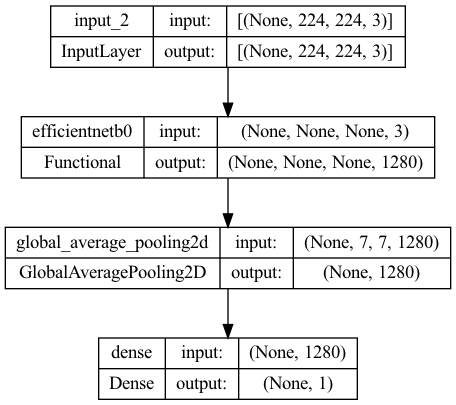

In [53]:
tf.keras.utils.plot_model(model_1,show_shapes=True)

In [54]:
# Complie model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [55]:
# Create EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,
    monitor = "loss"
)


In [56]:
# Fit model
import wandb
wandb.tensorboard.patch(root_logdir="logs")
wandb.init(sync_tensorboard=True)
history_1 = model_1.fit(train_data,
                        epochs=5,
                        validation_data=test_data,
                        callbacks=[early_stopping,
                                    create_tensorboard_callback("logs",model_1.name)],
                        class_weight=class_weight) # adjust for different numbers of classes

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jaehwan0. Use `wandb login --relogin` to force relogin


Saving TensorBoard log files to: logs/EfficientNetB0-V1/20221018-171933


2022-10-18 17:19:33.391615: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5


KeyboardInterrupt: 

In [57]:
model_1.evaluate(test_data)

  2/109 [..............................] - ETA: 2:44 - loss: 0.7991 - accuracy: 0.4375 

KeyboardInterrupt: 

In [ ]:
len(os.listdir("data/train/food_images/")), len(os.listdir("data/train/non_food_images/"))

## Save Model


In [ ]:
model_1.save("food_not_food_model_v0")

NameError: name 'model_1' is not defined

## Convert Model to TFLite for Deployment

In [ ]:
import tensorflow as tf
# Convert the model
saved_model_dir = "food_not_food_model_v0"
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Save the model
with open('food_not_food_model_v0.flite','wb') as f:
    f.write(tflite_model)